# YouTube trending videos

In [6]:
# import sys
# sys.path.append("..")

import warnings
warnings.filterwarnings('ignore')

from numpy import nan
%matplotlib inline
import random
import xgboost as xgb

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from lime.lime_tabular import LimeTabularExplainer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import recall_score, f1_score, precision_score, plot_roc_curve, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

from helpers.files import load_csv

plt.rcParams["figure.facecolor"] = "#a9a9a9"
random.seed(0)
np.random.seed(0)


def print_stats(clf, x_train, y_train, x_test, y_test):
    y_train_pred = clf.predict(x_train)
    print(f"Train accuracy: {accuracy_score(y_train, y_train_pred)}")
    print(f"Train precision: {precision_score(y_train, y_train_pred)}")
    print(f"Train recall: {recall_score(y_train, y_train_pred)}")
    print(f"Train F1: {f1_score(y_train, y_train_pred)}\n")
    ax = plt.gca()
    plot_roc_curve(clf, x_train, y_train, name="Train", ax=ax)

    y_test_pred = clf.predict(x_test)
    print(f"Test accuracy: {accuracy_score(y_test, y_test_pred)}")
    print(f"Test precision: {precision_score(y_test, y_test_pred)}")
    print(f"Test recall: {recall_score(y_test, y_test_pred)}")
    print(f"Test F1: {f1_score(y_test, y_test_pred)}\n")
    plot_roc_curve(clf, x_test, y_test, name="Test", ax=ax)
    plt.show()

### Wczytanie danych

In [7]:
load_filtered = True
if load_filtered:
    videos = load_csv("ped6_filtered_data")[0]
else:
    videos = load_csv("ped6_data")[0]

videos = videos.sample(frac=1).reset_index(drop=True)
videos.head(5)
print(len(videos))

12769


### Przygotowanie danych

Train: (10215, 74)
Test: (2554, 74)


,title_len,publish_time_day_of_week,gray_mean_score,color_mean_score,edges_score,entropy_score,title_tfidf_10,title_tfidf_2017,title_tfidf_best,title_tfidf_blackpink,...,tags_tfidf_interview,tags_tfidf_late,tags_tfidf_live,tags_tfidf_makeup,tags_tfidf_music,tags_tfidf_new,tags_tfidf_news,tags_tfidf_review,tags_tfidf_show,tags_tfidf_sport
0,0.536082,0.833333,0.243988,0.555517,0.417947,0.024327,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.432355
1,0.721649,0.166667,0.545909,0.708511,0.480639,0.086253,0.0,0.0,0.0,0.0,...,0.949016,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000
2,0.453608,0.666667,0.319708,0.584645,0.650277,0.032637,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.754576,0.000000
3,0.257732,0.833333,0.466823,0.498824,0.313153,0.047744,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000
4,0.422680,0.666667,0.693762,0.422152,0.463737,0.054544,0.0,0.0,0.0,0.0,...,0.000000,0.540177,0.0,0.0,0.0,0.0,0.43869,0.0,0.421712,0.000000


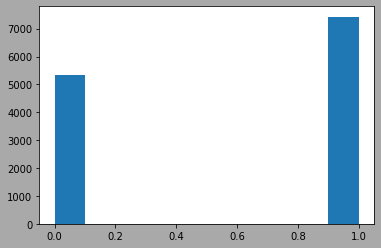

In [8]:
y = videos["trending"]
plt.hist(y)
x = videos.loc[:, videos.columns != "trending"]

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=0)

x_train_stats = x_train.mean()

x_train = x_train.fillna(x_train_stats)
x_test = x_test.fillna(x_train_stats)

scaler = MinMaxScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x.columns)

print(f"Train: {x_train.shape}")
print(f"Test: {x_test.shape}")
x_train.head(5)

### Wybór miar oceny klasyfikatorów

Accuracy
TODO wyjaśnij wybór.

### Wybór pierwszego klasyfikatora

RandomForest
TODO uzasadnij wybór.

In [9]:
param_grid = {
    "reduce_dim__k": [5, 10, 20, 25, 30],  # range(1, 50, 5),
    "classifier__max_depth": [4, 8, 10],
    "classifier__min_samples_leaf": [1, 2],  # 2, 4],
    "classifier__n_estimators": [10, 50, 100, 200]

}

pipeline = Pipeline([
    ("reduce_dim", SelectKBest(chi2)),
    ("classifier", RandomForestClassifier())
])

grid_search = GridSearchCV(pipeline, n_jobs=8, param_grid=param_grid, cv=10, verbose=1, scoring="f1")
grid_search.fit(x_train, y_train)
print(grid_search.best_params_)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits
{'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 200, 'reduce_dim__k': 30}



### Uczenie pierwszego klasyfikatora

In [10]:
k = grid_search.best_params_["reduce_dim__k"]
max_depth = grid_search.best_params_["classifier__max_depth"]
min_samples_leaf = grid_search.best_params_["classifier__min_samples_leaf"]
n_estimators = grid_search.best_params_["classifier__n_estimators"]
# Tree on Random Forest
select = SelectKBest(chi2, k=k)

x_train_selected = select.fit_transform(x_train, y_train)
x_test_selected = select.transform(x_test)

mask = select.get_support()
new_features = [feature for supported, feature in zip(mask, x.columns.values) if supported]

x_train_selected = pd.DataFrame(x_train_selected, columns=new_features)
x_test_selected = pd.DataFrame(x_test_selected, columns=new_features)

rf = RandomForestClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf
)
rf.fit(x_train_selected, y_train)


RandomForestClassifier(max_depth=10, n_estimators=200)

### Testowanie pierwszego klasyfikatora

Train accuracy: 0.7161037689672051
Train precision: 0.6840067747398983
Train recall: 0.9515314708852238
Train F1: 0.7958896396396397

Test accuracy: 0.6883320281910729
Test precision: 0.6642857142857143
Test recall: 0.9387617765814267
Test F1: 0.7780256553262689



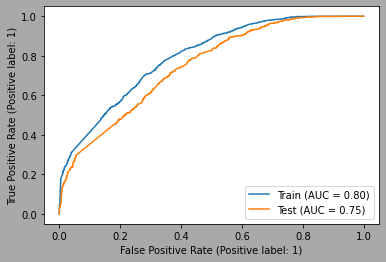

In [11]:
print_stats(rf, x_train_selected, y_train, x_test_selected, y_test)
rf_pred = lambda x: rf.predict_proba(x).astype(float)


### Interpretacja predykcji pierwszego klasyfikatora

Intercept -0.5620802451329241
Prediction_local [0.60277256]
Right: 0.5719616928690019


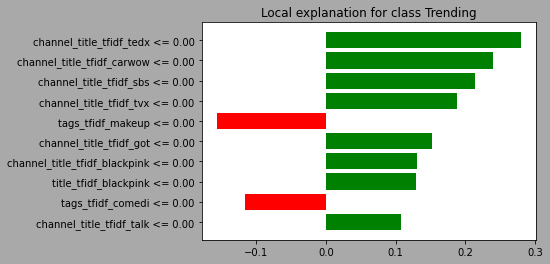

In [12]:
explainerRF = shap.TreeExplainer(rf)

shap_values_RF_test = explainerRF.shap_values(x_test_selected, approximate=True)
shap_values_RF_train = explainerRF.shap_values(x_train_selected, approximate=True)
# Random Forest
#TODO check index
# df_shap_RF_test = pd.DataFrame(shap_values_RF_test[1], columns=x_test.columns.values)
# df_shap_RF_train = pd.DataFrame(shap_values_RF_train[1], columns=x_train.columns.values)

# LIME has one explainer for all models
explainer = LimeTabularExplainer(
    x_train_selected.values,
    feature_names=x_train_selected.columns.values.tolist(),
    training_labels=[0, 1],
    class_names=['Non trending', "Trending"],
    verbose=True,
)

j = 0

exp = explainer.explain_instance(x_test_selected.loc[[j]].values[0], rf_pred)
exp.save_to_file("lime.html")
# exp.show_in_notebook(show_table=True)
fig = exp.as_pyplot_figure()
plt.show(fig)

In [13]:
j = 123
x_test_selected.loc[[j]]

,title_tfidf_blackpink,title_tfidf_first,title_tfidf_highlight,channel_title_tfidf_blackpink,channel_title_tfidf_carwow,channel_title_tfidf_got,channel_title_tfidf_late,channel_title_tfidf_news,channel_title_tfidf_nfl,channel_title_tfidf_night,...,tags_tfidf_anim,tags_tfidf_comedi,tags_tfidf_food,tags_tfidf_funni,tags_tfidf_late,tags_tfidf_makeup,tags_tfidf_new,tags_tfidf_news,tags_tfidf_show,tags_tfidf_sport
123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.892188,0.0,0.0,0.277525,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# shap.force_plot(explainerRF.expected_value, shap_values_RF_test[j], x_test.iloc[[j]])
print(y_test.to_numpy()[j])
shap_val = explainerRF.shap_values(x_test_selected.loc[[j]], approximate=True)
print(np.array(shap_val).shape)
# initialize js for SHAP

shap.initjs()
shap.force_plot(explainerRF.expected_value[1], shap_val[1], x_test_selected.loc[[j]])


0
(2, 1, 30)


In [15]:
j = 2000
x_test_selected.loc[[j]]

,title_tfidf_blackpink,title_tfidf_first,title_tfidf_highlight,channel_title_tfidf_blackpink,channel_title_tfidf_carwow,channel_title_tfidf_got,channel_title_tfidf_late,channel_title_tfidf_news,channel_title_tfidf_nfl,channel_title_tfidf_night,...,tags_tfidf_anim,tags_tfidf_comedi,tags_tfidf_food,tags_tfidf_funni,tags_tfidf_late,tags_tfidf_makeup,tags_tfidf_new,tags_tfidf_news,tags_tfidf_show,tags_tfidf_sport
2000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
print(y_test.to_numpy()[j])
# shap.force_plot(explainerRF.expected_value, shap_values_RF_test[j], x_test.iloc[[j]])
shap_val = explainerRF.shap_values(x_test_selected.loc[[j]], approximate=True)
print(np.array(shap_val).shape)
# initialize js for SHAP
shap.initjs()
shap.force_plot(explainerRF.expected_value[1], shap_val[1], x_test_selected.loc[[j]])


0
(2, 1, 30)


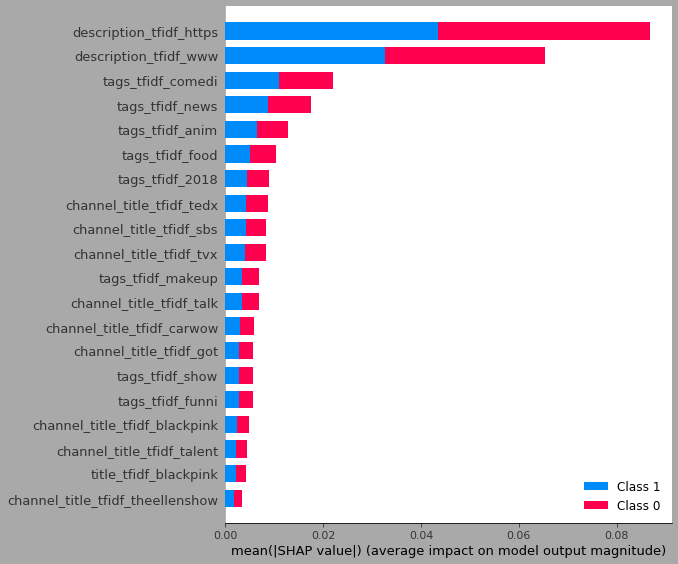

In [17]:
shap.summary_plot(shap_val, x_test_selected.loc[[j]])

### Interpretacja treningowych danych

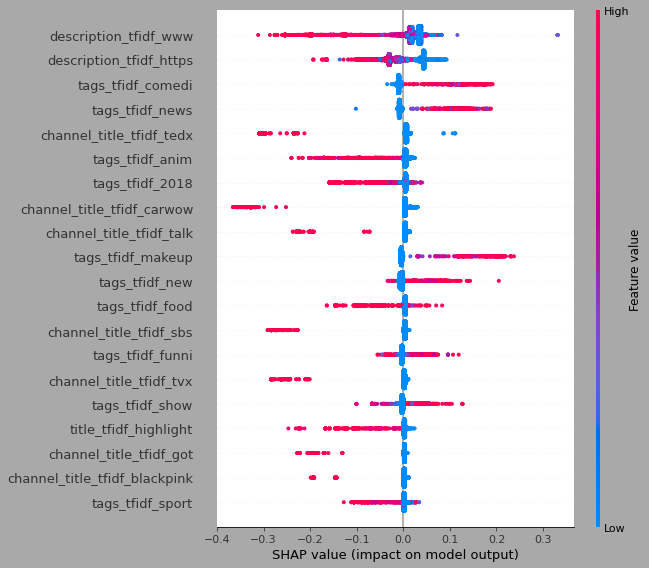

In [18]:
shap.summary_plot(shap_values_RF_train[1], x_train_selected)

### Interpretacja testowych danych

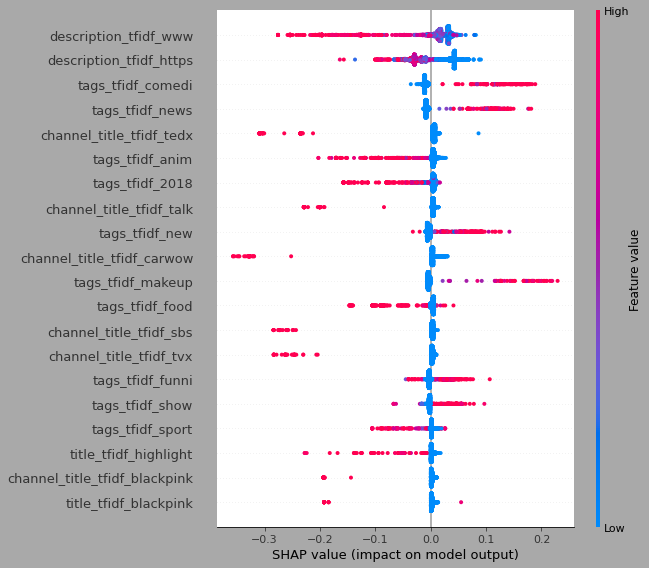

In [19]:
shap.summary_plot(shap_values_RF_test[1], x_test_selected)

# TODO pomyśl o filtrowaniu danych
# TODO pomyśl o odfiltrowaniu innych języków

### Wybór drugiego klasyfikatora

Jako drugi klasyfikator został wybrany XGBoost, ponieważ jest znany z tego że osiąga dobre wyniki (nawet na niezbalansowanych danych) jak i bardzo dobrze wyjaśnialny, poprzez to że w swojej mechanice ma zawarte ważności cech oraz prez zastosowanie boostingu oraz regularyzacji wewnątrz modelu.

### Testowanie klasyfikatora

In [20]:
xgbclf_base = xgb.XGBClassifier(n_estimators=1000, use_label_encoder=False, verbosity=0)

print(xgbclf_base.fit(x_train, y_train))

y_pred = xgbclf_base.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['trending', 'non-trending']))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=0)
              precision    recall  f1-score   support

    trending       0.81      0.79      0.80      1068
non-trending       0.85      0.86      0.86      1486

    accuracy                           0.83      2554
   macro avg       0.83      0.83      0.83      2554
weighted avg       0.83      0.83      0.83      2554



### Uczenie drugiego klasyfikatora

**Selekcja cech**

Selekcja cech została przeporwadzona poprzez analizę upadku trafności wraz z ograniczaniem liczby cech modelu

In [21]:
from sklearn.feature_selection import SelectFromModel

thresholds = sorted(xgbclf_base.feature_importances_)

selection_model = xgb.XGBClassifier(n_estimators=10, use_label_encoder=False, verbosity=0)
selection_model.fit(x_train, y_train)
print("Base accuracy: %.2f%%" % (accuracy_score(y_test, selection_model.predict(x_test)) * 100))

for thresh in thresholds:
    selection = SelectFromModel(xgbclf_base, threshold=thresh, prefit=True)
    select_x_train = selection.transform(x_train)
    selection_model = xgb.XGBClassifier(n_estimators=10, use_label_encoder=False, verbosity=0)
    selection_model.fit(select_x_train, y_train)
    select_x_test = selection.transform(x_test)
    y_pred = selection_model.predict(select_x_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_x_train.shape[1], accuracy * 100.0), accuracy)

Base accuracy: 76.27%
Thresh=0.000, n=74, Accuracy: 76.27% 0.7627251370399374
Thresh=0.000, n=74, Accuracy: 76.27% 0.7627251370399374
Thresh=0.000, n=74, Accuracy: 76.27% 0.7627251370399374
Thresh=0.000, n=74, Accuracy: 76.27% 0.7627251370399374
Thresh=0.000, n=74, Accuracy: 76.27% 0.7627251370399374
Thresh=0.000, n=74, Accuracy: 76.27% 0.7627251370399374
Thresh=0.000, n=74, Accuracy: 76.27% 0.7627251370399374
Thresh=0.002, n=67, Accuracy: 76.27% 0.7627251370399374
Thresh=0.002, n=66, Accuracy: 76.27% 0.7627251370399374
Thresh=0.003, n=65, Accuracy: 76.27% 0.7627251370399374
Thresh=0.003, n=64, Accuracy: 76.27% 0.7627251370399374
Thresh=0.003, n=63, Accuracy: 76.27% 0.7627251370399374
Thresh=0.004, n=62, Accuracy: 76.43% 0.7642913077525451
Thresh=0.004, n=61, Accuracy: 74.94% 0.7494126859827721
Thresh=0.004, n=60, Accuracy: 74.94% 0.7494126859827721
Thresh=0.005, n=59, Accuracy: 74.94% 0.7494126859827721
Thresh=0.005, n=58, Accuracy: 74.63% 0.7462803445575568
Thresh=0.005, n=57, Accura

Jak rozsądną wartość ilość cech została ograniczona do 51

### Interpretacja predykcji

In [22]:
thresh = thresholds[-51]
selection = SelectFromModel(xgbclf_base, threshold=thresh, prefit=True)
x_train_selected = selection.transform(x_train)

selection_model = xgb.XGBClassifier(n_estimators=10, use_label_encoder=False, verbose=0)
selection_model.fit(x_train_selected, y_train)

x_test_selected = selection.transform(x_test)
y_pred = selection_model.predict(x_test_selected)
accuracy = accuracy_score(y_test, y_pred)
print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, x_train_selected.shape[1], accuracy * 100.0))

mask = selection.get_support()
new_features = [feature for supported, feature in zip(mask, x.columns.values) if supported]

x_train_selected = pd.DataFrame(x_train_selected, columns=new_features)
x_test_selected = pd.DataFrame(x_test_selected, columns=new_features)

Thresh=0.006, n=51, Accuracy: 76.27%


**Strojenie parametrów**

Strojenie odbywa się na modelu o mniejszej ilości estymatorów (ze względu na czas obliczeń)

In [23]:
params = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 2, 5],
    'max_depth': [3, 6, 9, 15]
}
xgbclf_par = xgb.XGBClassifier(n_estimators=10, use_label_encoder=False, nthread=1, verbosity=0)
grid_search = GridSearchCV(xgbclf_par, n_jobs=8, param_grid=params, cv=3, verbose=1)
grid_search.fit(x_train_selected, y_train)
print(grid_search.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
{'gamma': 2, 'max_depth': 15, 'min_child_weight': 1}


In [24]:
print(grid_search.cv_results_['mean_test_score'])
print(grid_search.best_score_)

[0.69877631 0.69720999 0.69613314 0.75741557 0.75389134 0.74723446
 0.79030837 0.78590308 0.7773862  0.81576114 0.80695056 0.79050416
 0.69877631 0.69720999 0.69613314 0.75594714 0.75428292 0.74831131
 0.79069995 0.78081253 0.76730299 0.81722956 0.80372002 0.79520313
 0.69867841 0.69740578 0.69730788 0.75496818 0.75487029 0.7442976
 0.78306412 0.77395986 0.77063142 0.80812531 0.79569261 0.79011258]
0.8172295643661283


### Uczenie drugiego klasyfikatora

In [25]:
min_child_weight = grid_search.best_params_["min_child_weight"]
max_depth = grid_search.best_params_["max_depth"]
gamma = grid_search.best_params_["gamma"]

xgbclf = xgb.XGBClassifier(n_estimators=1000, use_label_encoder=False, nthread=-1, verbosity=0,
                           objective='binary:logistic',
                           min_child_weight=min_child_weight,
                           max_depth=max_depth,
                           gamma=gamma)

xgbclf.fit(x_train_selected, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=16, nthread=-1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=0)

Train accuracy: 0.9334312285854136
Train precision: 0.923671497584541
Train recall: 0.9653315382026254
Train F1: 0.9440421329822252

Test accuracy: 0.8347689898198903
Test precision: 0.8320848938826467
Test recall: 0.8970390309555855
Test F1: 0.8633419689119171



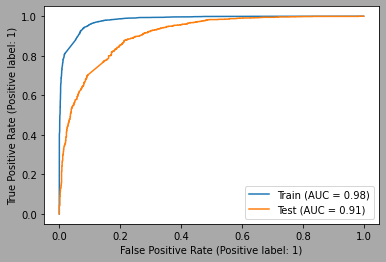

Test results: 
               precision    recall  f1-score   support

    trending       0.84      0.75      0.79      1068
non-trending       0.83      0.90      0.86      1486

    accuracy                           0.83      2554
   macro avg       0.84      0.82      0.83      2554
weighted avg       0.84      0.83      0.83      2554



In [26]:
print_stats(xgbclf, x_train_selected, y_train, x_test_selected, y_test)
y_pred = xgbclf.predict(x_test_selected)
print("Test results: \n", classification_report(y_test, y_pred, target_names=['trending', 'non-trending']))

Ważność atrybutów wg. weight pokazuje jak często w drzewach pojawiają się dane cechy

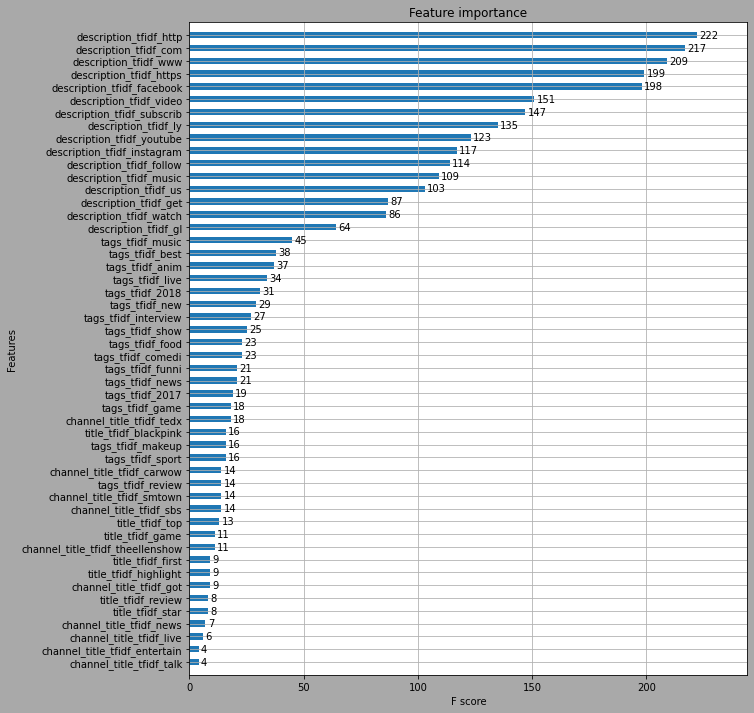

In [27]:
fig, ax = plt.subplots(figsize=(10, 12))
xgb.plot_importance(xgbclf, max_num_features=50, height=0.5, ax=ax, importance_type='weight')
plt.show()

Ważność atrybutów wg. gain ozancza jak dużą część trafności wnosi dana cecha

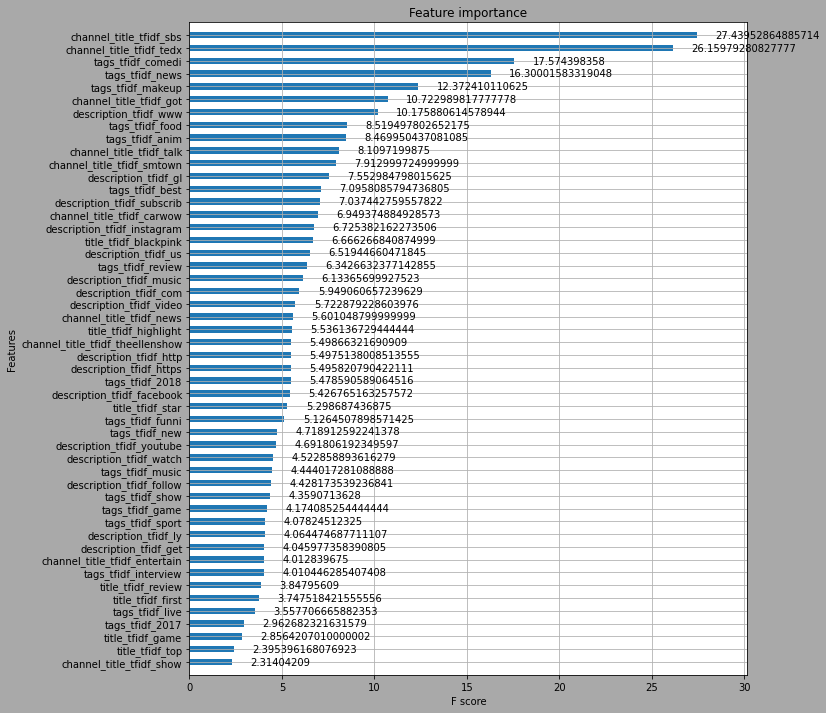

In [28]:
fig, ax = plt.subplots(figsize=(10, 12))
xgb.plot_importance(xgbclf, max_num_features=50, height=0.5, ax=ax, importance_type='gain')
plt.show()

In [30]:
xgbclf_base = xgb.XGBClassifier(n_estimators=10, use_label_encoder=False, verbosity=0)

print(xgbclf_base.fit(x_train, y_train))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=0)


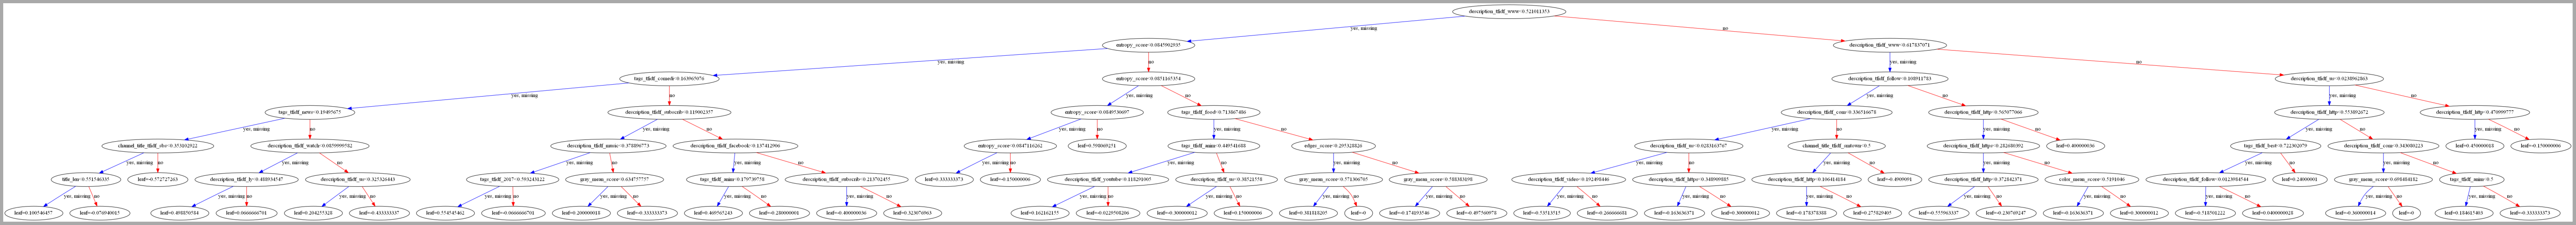

In [31]:
plt.rcParams['figure.figsize'] =  [100, 100]
xgb.plot_tree(xgbclf_base,num_trees=0)
plt.show()

# fig = plt.gcf()
# fig.set_size_inches(1000, 500)
# fig.show()

### SHAP

Intercept -1.0730583756013112
Prediction_local [0.65585513]
Right: 0.8205682039260864


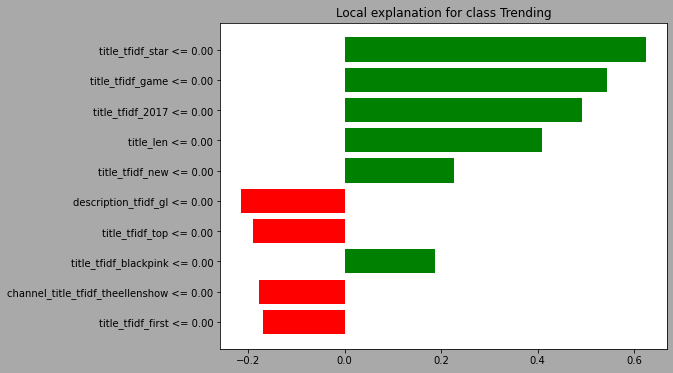

In [32]:
plt.rcParams['figure.figsize'] = [8, 6]
xgb_pred = lambda x: xgbclf.predict_proba(x).astype(float)

# LIME has one explainer for all models,

explainer = LimeTabularExplainer(
    x_train_selected.values,
    feature_names=x_train.columns.values.tolist(),
    training_labels=[0, 1],
    class_names=['Non trending', "Trending"],
    verbose=True)

j = 0

exp = explainer.explain_instance(x_test_selected.loc[[j]].values[0], xgb_pred)
exp.save_to_file("lime2.html")
# exp.show_in_notebook(show_table=True),
fig = exp.as_pyplot_figure()
plt.show(fig)

In [33]:
x_sampled = x_test_selected.sample(100, random_state=0)
explainerXgb = shap.TreeExplainer(xgbclf)
shap_values = explainerXgb.shap_values(x_sampled)

In [34]:
shap.force_plot(explainerXgb.expected_value, shap_values[1], x_sampled.iloc[1])

In [35]:
shap_values = explainerXgb.shap_values(x_train_selected)
shap.force_plot(explainerXgb.expected_value, shap_values[1], x_train_selected.iloc[1])

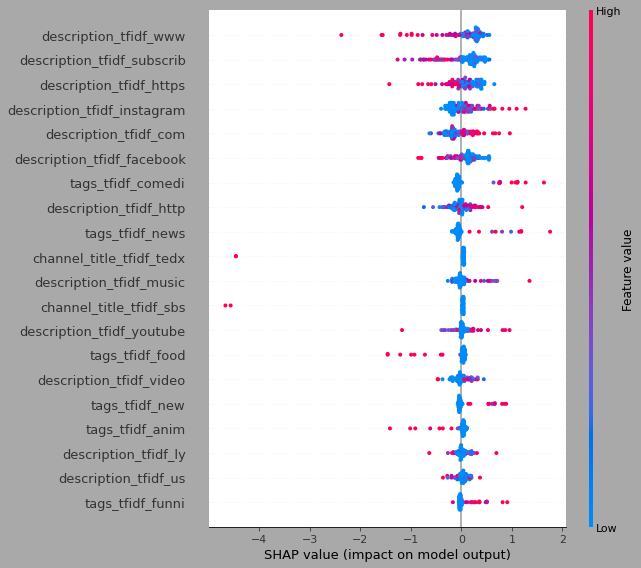

In [36]:
shap_values = explainerXgb.shap_values(x_sampled)
shap.summary_plot(shap_values, x_sampled)

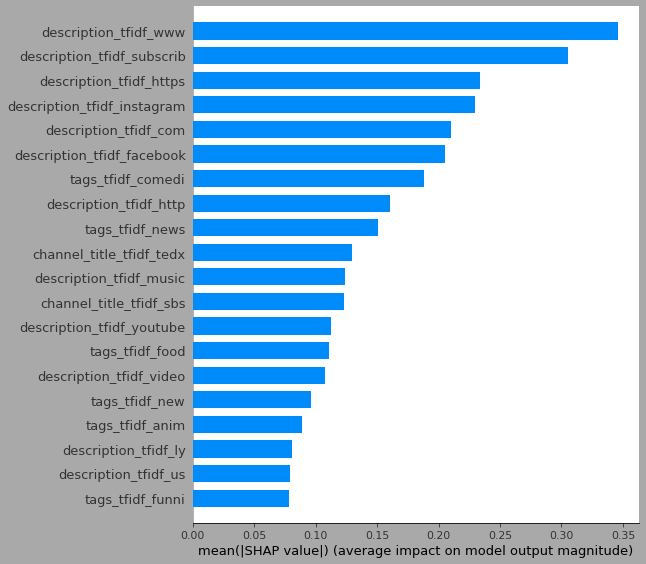

In [37]:
shap.summary_plot(shap_values, x_sampled, plot_type="bar")

In [ ]:
Jak można zauważyć bardzo duzy wpływ ma ilość linków oraz zachęcanie do subskrybcji

### Porównanie wyników klasyfikatorów
Sprośród klasyfikatorów ewidentnie lepiej wypadł klasyfikator XGBoost, prawdopoodbnie przez to że stosując metody ensamble, jest w stanie lepiej dopasować sie danych. Mimo to model RF osiągnął lepsze wyniki recall w porównaniu do xgboosta, dla którego strojenie parametrów przyniosło efekt lepszych wyników dla rozpoznawania klasy trending kosztem wyników dla non-trending. Jednak pomimo tej jednej większej metryki w Rf, dalej można łatwo stwierdzić że lepszym modelem do kalsyfikacji jest XGBoost.

### Wiedza dla klienta

Analizując te dane można znaleźć parę porad jakie można stosować. Wyniki z danych niefiltrowanych są w tym przypadku mniej ważne, bo wynikające głównie z nich wnioski to
- Być Jimmy'iem Fallonem
- Prowadzić duży kanał informacyjny (ale nie bbc)
- Wypuszczać trailery do dużych filmów (najlepiej Star Wars)
- prowadzić kanał z muzyką vevo
- nie próbować wybić się na TEDx talkach

Wiedza to jednak jest mało praktyczna w wykonaniu dlatego patrząc na odlitrowane wyniki można wyodrębnić zachowania, które są bardziej realne:
- Prowadzić kanał komediowy, muzyczny, makeupowy, lub gamingowy
- Prowadzić inne portale społecznościowe i do nich linkować m.in instagram
- posiadać na minatruce wiele elementów z wyraźnymi krawędziami
- uważać na tagi jakie się daje (popularne commedy,funny, news)
- linkwać do innych filmów na yt
- robić rzeczy z tagiem new, czyli rzeczy "na czasie"
- prowadzić transmisje na żywo, lub bardzo świeże

Rzeczy których lepiej się wystrzegać:
- za dużo linków w opisie
- za duże zachęcanie do subskrybowania
- prowadzić kanał związany z jedzeniem
- linkwać dużo do facebooka
- posiadać zbyt długą nazwę kanału
- robić kontent animowany
- wrzucać edytowane najciekawsze fragmenty tzw. "highlights"
- prowadzić kanał w języku obcym, czy tłumaczyć kontent angielski na j. obcy (głównie hiszpański i niemiecki)
- używać skróconych linków bit.ly
- używać "sbs" w nazwie kanału

Profil charakterystycznych wartości atrybutów dla klasy trending

Co trzeba robić?

Czego się wystrzegać?